# HW4 - MobileNet V1 and V2: A PyTorch Tutorial
[CE40477: Machine Learning](https://www.sharifml.ir/)

__Course Instructor__: Dr. Sharifi-Zarchi

__Notebook Author__: Amirmahdi Meighani



In this notebook, we present a comprehensive guide to understanding and implementing the MobileNet V1 and V2 architectures using PyTorch. MobileNet is a highly regarded family of deep learning architectures, designed by Google with a primary focus on creating models that are both lightweight and computationally efficient. These models are particularly optimized for mobile and embedded devices, where resources like memory, processing power, and battery life are often limited.

MobileNet stands out for its unique design principles, particularly the use of depthwise separable convolutions, which significantly reduce the number of parameters and computation required compared to traditional convolutional neural networks. This makes MobileNet an ideal choice for applications that demand real-time performance, such as mobile apps, IoT devices, and on-device machine learning tasks.

Another application for MobileNet is edge deployment. Its scalable architecture allows customization through width and resolution multipliers, making it adaptable to the resource constraints of various devices. Additionally, MobileNet's low power consumption is ideal for battery-operated systems, and its compatibility with frameworks like TensorFlow Lite and hardware accelerators like Edge TPUs ensures seamless deployment. These features make it perfect for real-time, on-device applications such as object detection, face recognition, and other AI tasks at the edge.

Throughout this notebook, we will delve into both MobileNet V1 and V2 architectures, examining how each version builds on the previous one to enhance both efficiency and accuracy. By implementing these architectures step-by-step in PyTorch, we aim to provide a solid foundation for anyone interested in leveraging MobileNet’s capabilities for mobile and edge computing applications.

### Objectives
- Understand the structure and advantages of MobileNet V1 and V2
- Learn the theory of depthwise separable convolutions and inverted residuals
- Implement and use MobileNet V1 and V2 in PyTorch
- Use transfer learning for better accuracy


In [1]:
# Enter your information here
first_and_last_name = 'Amirhosein Rezaei'
std_number = '401105989'

![architecture](https://media.springernature.com/lw685/springer-static/image/art%3A10.1038%2Fs41598-024-53349-w/MediaObjects/41598_2024_53349_Fig2_HTML.png)

## 1. MobileNet V1

### Theory
MobileNet V1 was designed by Google to create an efficient and lightweight neural network model for mobile and embedded applications. The architecture is built on **depthwise separable convolutions**, which reduce computation cost and model size compared to traditional convolutions.

- **Depthwise Separable Convolution**: A depthwise separable convolution splits a standard convolution into two parts:
  1. **Depthwise Convolution**: This operation applies a single filter to each input channel independently. It significantly reduces computation by processing each channel separately.
  2. **Pointwise Convolution (1x1 Convolution)**: This operation combines the channels outputted by the depthwise convolution by applying a 1x1 filter. It performs a linear combination across the channels, allowing the model to learn interactions between different channels.

To learn more about this convolution you can check this [link](https://medium.com/@zurister/depth-wise-convolution-and-depth-wise-separable-convolution-37346565d4ec)


Compared to traditional convolution, which combines spatial and channel information simultaneously, depthwise separable convolutions drastically reduce the number of computations.

MobileNet V1 also introduces two scaling hyperparameters:
- **Width Multiplier** (α): Scales the number of channels in each layer, allowing you to shrink the model's width (number of channels).
- **Resolution Multiplier** (ρ): Reduces the resolution of the input image, further decreasing computational cost.


Now let's implement a MobileNet from scratch. Start by importing the necessary libraries.

In [2]:
# Importing libraries

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import time
from PIL import Image

import torchvision
from torchvision import transforms

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Subset
from typing import Tuple, List
from torch.optim import Optimizer
from torch.utils.data import DataLoader


Check your device. We recommend using GPU. You can use GPU with google colab.

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


Before starting we want you to have some knowledge about Batch Normalization.

### **Understanding Batch Normalization**

Batch Normalization (BatchNorm) is a technique designed to improve the training of deep neural networks by normalizing the inputs to each layer. It helps address the issue of "internal covariate shift," where the distribution of activations changes as training progresses.

Batch Normalization consists of two main steps: **Normalization** and **Scaling/Shift**.

### 1. **Normalization**

Given a batch of data $X$ with $m$ samples and $n$ features, Batch Normalization first computes the **mean** ($\mu$) and **variance** ($\sigma^2$) for each feature across the batch:

$$
\mu = \frac{1}{m} \sum_{i=1}^{m} x_i, \quad
\sigma^2 = \frac{1}{m} \sum_{i=1}^{m} (x_i - \mu)^2
$$

Each feature is then normalized using:

$$
\hat{x}_i = \frac{x_i - \mu}{\sqrt{\sigma^2 + \epsilon}}
$$

where:
- $\epsilon$: A small constant added to avoid division by zero.



### 2. **Scaling and Shifting**

To allow the model to learn the optimal feature representation, the normalized value $\hat{x}_i$ is scaled and shifted using learnable parameters $\gamma$ (scale) and $\beta$ (shift):

$$
y_i = \gamma \hat{x}_i + \beta
$$



### **Complete Formula**

The full Batch Normalization transformation for each feature is:

$$
y_i = \gamma \frac{x_i - \mu}{\sqrt{\sigma^2 + \epsilon}} + \beta
$$



## **Why Use Batch Normalization?**

1. **Stabilizes Training**: By normalizing inputs, gradients are more stable, which accelerates convergence.
2. **Reduces Dependence on Initialization**: Makes the network less sensitive to weight initialization.
3. **Acts as a Regularizer**: Introduces noise due to batch statistics, helping reduce overfitting.
4. **Improves Generalization**: Often eliminates the need for other regularization techniques like Dropout.



In [4]:
def batch_normalization(x, gamma, beta, epsilon=1e-5):
    """
    Performs batch normalization on the input data.

    Parameters:
        x (numpy.ndarray): Input data of shape (batch_size, features).
        gamma (float): Scale parameter.
        beta (float): Shift parameter.
        epsilon (float): Small value to avoid division by zero.

    Returns:
        numpy.ndarray: Normalized and scaled data.
    """
    mean = np.mean(x, axis=0)
    variance = np.var(x, axis=0)
    x_normalized = (x - mean) / np.sqrt(variance + epsilon)
    out = gamma * x_normalized + beta
    return out


In [5]:
# Example batch data (4 samples, 3 features)
x = np.array([[1.0, 2.0, 3.0],
              [4.0, 5.0, 6.0],
              [7.0, 8.0, 9.0],
              [10.0, 11.0, 12.0]])

# Parameters for scaling and shifting
gamma = 1.0
beta = 0.0

# Apply batch normalization
normalized_data = batch_normalization(x, gamma, beta)

# Print results
print("Original Data:\n", x)
print("\nNormalized Data:\n", normalized_data)

Original Data:
 [[ 1.  2.  3.]
 [ 4.  5.  6.]
 [ 7.  8.  9.]
 [10. 11. 12.]]

Normalized Data:
 [[-1.34164019 -1.34164019 -1.34164019]
 [-0.4472134  -0.4472134  -0.4472134 ]
 [ 0.4472134   0.4472134   0.4472134 ]
 [ 1.34164019  1.34164019  1.34164019]]


We need some data for training, testing and validation. in this part we use CIFAR-10 dataset. It is a famous dataset in vision. CIFAR-10 contains 60,000 32x32 images in 10 classes.

> **Note**: MobileNet models perform best on larger image sizes (like 224x224), but CIFAR-10 is used here as a simple example dataset.


In [6]:
# TRANSFORMS
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.5, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071, 0.4867, 0.4408],
                         std=[0.2675, 0.2565, 0.2761]),
])

transform_test = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071, 0.4867, 0.4408],
                         std=[0.2675, 0.2565, 0.2761]),
])




# TRAIN DATA
train_set = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)

train_loader = DataLoader(Subset(train_set, range(len(train_set) // 2)), batch_size=128, shuffle=False, num_workers=2)

# VALIDATION DATA
val_set = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)

val_loader = DataLoader(val_set, batch_size=128, shuffle=False, num_workers=2)

100%|██████████| 170498071/170498071 [00:03<00:00, 49736496.10it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Explain what we did in transfor train and tranform test:<br/>
transform_train:
- Augmentation: Randomly resizes and crops images to \(224 \times 224\) (scale 0.5–1.0) and applies horizontal flips for variability.
- Conversion: Converts images to tensors and normalizes channels using mean `[0.5071, 0.4867, 0.4408]` and std `[0.2675, 0.2565, 0.2761]`.

transform_test:
- Standardization: Resizes all images to \(224 \times 224\) without augmentation.
- Conversion: Converts to tensors and applies the same normalization as training for consistency.

for showing images in this notebook we define a function and use it everywhere. you should test your fucntion for 32 first images of dataset and see how our data augmentaion worked. Also print labels to see the format.

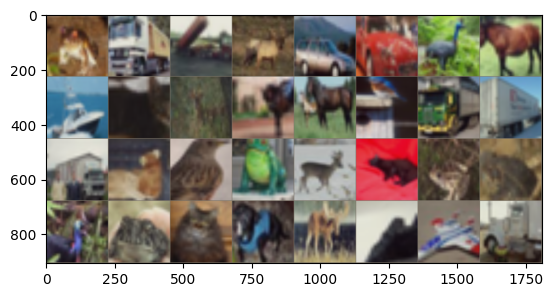

tensor([6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6, 4, 3, 6, 6,
        2, 6, 3, 5, 4, 0, 0, 9, 1, 3, 4, 0, 3, 7, 3, 3, 5, 2, 2, 7, 1, 1, 1, 2,
        2, 0, 9, 5, 7, 9, 2, 2, 5, 2, 4, 3, 1, 1, 8, 2, 1, 1, 4, 9, 7, 8, 5, 9,
        6, 7, 3, 1, 9, 0, 3, 1, 3, 5, 4, 5, 7, 7, 4, 7, 9, 4, 2, 3, 8, 0, 1, 6,
        1, 1, 4, 1, 8, 3, 9, 6, 6, 1, 8, 5, 2, 9, 9, 8, 1, 7, 7, 0, 0, 6, 9, 1,
        2, 2, 9, 2, 6, 6, 1, 9])


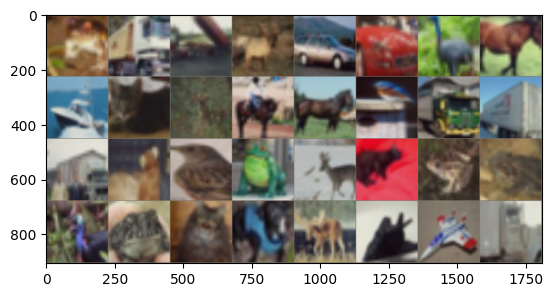

In [7]:
def imshow(img):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = img.numpy().transpose((1, 2, 0))
    img = img * std + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.show()

# show some training images with shuffle=False and labels
dataiter = iter(train_loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[:32]))
print(labels)
# show them again to check the augmentation
dataiter = iter(train_loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[:32]))
# create train loader with shuffle true
train_loader = DataLoader(train_set, batch_size=128, shuffle=True, num_workers=2)

For trainig our models, we first define some functions to make our job easier. fill the functions according to their signature or you can change them according to your needs.

In [8]:
MODEL_SAVE_PATH = './model.pt'


# Assuming global variables 'device' and 'MODEL_SAVE_PATH' are defined elsewhere.

def fit_epoch(
    model: nn.Module,
    data_loader: DataLoader,
    criterion: nn.Module,
    optimizer: Optimizer,
    train_mode: bool = False
) -> List[float]:
    """
    Runs one epoch of training or validation.

    Args:
        model (nn.Module): The PyTorch model to train or evaluate.
        data_loader (DataLoader): The DataLoader for the dataset.
        criterion (nn.Module): Loss function.
        optimizer (Optimizer): Optimizer for training.
        train_mode (bool): Flag indicating training (True) or validation (False).

    Returns:
        List[float]: List of losses for the epoch.
    """
    if train_mode:
        model.train()
    else:
        model.eval()
    epoch_losses = []
    for inputs, labels in tqdm(data_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        with torch.set_grad_enabled(train_mode):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            if train_mode:
                loss.backward()
                optimizer.step()
        epoch_losses.append(loss.item())
    return epoch_losses



def train(
    train_loader: DataLoader,
    val_loader: DataLoader,
    model: nn.Module,
    epochs: int,
    lr: float = 1e-3
) -> Tuple[List[float], List[float]]:
    """
    Trains a model and validates it after each epoch.

    Args:
        train_loader (DataLoader): DataLoader for training data.
        val_loader (DataLoader): DataLoader for validation data.
        model (nn.Module): The PyTorch model to train.
        epochs (int): Number of training epochs.
        lr (float): Learning rate for the optimizer.

    Returns:
        Tuple[List[float], List[float]]: Lists of training and validation losses.
    """
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    train_losses, val_losses = [], []
    best_val_loss = float('inf')
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        train_epoch_losses = fit_epoch(model, train_loader, criterion, optimizer, train_mode=True)
        val_epoch_losses = fit_epoch(model, val_loader, criterion, optimizer, train_mode=False)
        train_losses.extend(train_epoch_losses)
        val_loss_mean = np.mean(val_epoch_losses)
        val_losses.append(val_loss_mean)
        print(f"Train Loss: {np.mean(train_epoch_losses):.4f} | Val Loss: {val_loss_mean:.4f}")
        if val_loss_mean < best_val_loss:
            best_val_loss = val_loss_mean
            torch.save(model.state_dict(), MODEL_SAVE_PATH)

    return train_losses, val_losses



def get_acc(
    model: nn.Module,
    val_loader: DataLoader
) -> float:
    """
    Calculates accuracy of the model on a validation dataset.

    Args:
        model (nn.Module): The PyTorch model.
        val_loader (DataLoader): DataLoader for validation data.

    Returns:
        float: Validation accuracy.
    """
    model.eval()
    total_correct = 0
    total_samples = 0
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            predictions = torch.argmax(outputs, dim=1)
            total_correct += (predictions == labels).sum().item()
            total_samples += labels.size(0)
    return total_correct / total_samples



def plot_losses(
    train_losses: List[float],
    val_losses: List[float],
    c_window: int = 10
) -> None:
    """
    Plots training and validation losses.

    Args:
        train_losses (List[float]): List of training losses.
        val_losses (List[float]): List of validation losses.
        c_window (int): Convolution window size for smoothing training losses.

    Returns:
        None
    """
    smoothed_train_losses = np.convolve(train_losses, np.ones(c_window) / c_window, mode='valid')
    epochs = len(val_losses)

    plt.figure(figsize=(10, 6))
    plt.plot(smoothed_train_losses, label="Training Loss (Smoothed)")
    plt.plot(
        [(i+1) * len(train_losses) / epochs for i in range(epochs)],
        val_losses,
        label="Validation Loss",
        marker="o",
    )
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.grid()
    plt.show()


Finally we can start creating the MobileNet model. The architecture is presented here:
![architecture](https://production-media.paperswithcode.com/methods/Screen_Shot_2020-06-22_at_4.26.15_PM_ko4FqXD.png)

You can see the related paper [here](https://arxiv.org/abs/1704.04861)

for cleaner implementation first complete these functions(Each layer consists of a depthwise separable convolution followed by a ReLU activation. The architecture efficiently reduces computations by using depthwise separable convolutions, making it suitable for mobile and embedded applications.):

In [9]:
def conv_bn(inp, oup, stride):
    # Define a standard convolutional layer with batch normalization and ReLU activation
    # Parameters:
    # inp: Number of input channels
    # oup: Number of output channels
    # stride: Stride size for the convolution
    return nn.Sequential(
        nn.Conv2d(inp, oup, kernel_size=3, stride=stride, padding=1, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU(inplace=True)
    )

def conv_dw(inp, oup, stride):
    # Define a depthwise separable convolution layer
    # Consists of depthwise convolution followed by pointwise convolution, each with batch normalization and ReLU activation
    # Parameters:
    # inp: Number of input channels
    # oup: Number of output channels
    # stride: Stride size for the depthwise convolution
    return nn.Sequential(
        nn.Conv2d(inp, inp, kernel_size=3, stride=stride, padding=1, groups=inp, bias=False),
        nn.BatchNorm2d(inp),
        nn.ReLU(inplace=True),
        nn.Conv2d(inp, oup, kernel_size=1, stride=1, padding=0, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU(inplace=True)
    )

Explain how using Depthwise Separable Convolutions helps us in reducing the number of parameters(calculate and compare number of parameters in normal convolution and depthwise convolution) and how it helps us in making the model faster.

  - Standard Convolution: \(C_in * C_out * k * k\).  
  - Depthwise Separable: \(C_in * k * (k + C_in) * C_out\).  
  Example (\(C_in = 32, C_out = 64, k = 3\)):  
  - Standard: \(18,432\) params.  
  - Depthwise Separable: \(3,648\) params (80% fewer).

  Fewer parameters reduce computations and memory usage, making models faster and more efficient for devices like mobiles.

Now please create your model.

In [10]:
class MobileNet(nn.Module):
    def __init__(self, n_class=1000):
        super(MobileNet, self).__init__()
        self.model = nn.Sequential(
            conv_bn(3, 32, stride=2),
            conv_dw(32, 64, stride=1),
            conv_dw(64, 128, stride=2),
            conv_dw(128, 128, stride=1),
            conv_dw(128, 256, stride=2),
            conv_dw(256, 256, stride=1),
            conv_dw(256, 512, stride=2),
            *[conv_dw(512, 512, stride=1) for _ in range(5)],
            conv_dw(512, 1024, stride=2),
            conv_dw(1024, 1024, stride=1),
            nn.AdaptiveAvgPool2d(1)
        )
        self.fc = nn.Linear(1024, n_class)

    def forward(self, x):
        x = self.model(x)
        x = x.view(-1, 1024)
        x = self.fc(x)
        return x

Let's train your model.(You can increase number of epochs or change lr but your accuracy should be above 65 and calculate training time)

In [11]:
epochs = 10
lr = 1e-3

model = MobileNet(10).to(device)
start_time = time.time()
train_losses, val_losses = train(train_loader, val_loader, model, epochs, lr)
training_time = time.time() - start_time
print(f"Training completed in {training_time:.2f} seconds.")

Epoch 1/10


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.4761 | Val Loss: 1.2044
Epoch 2/10


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.0675 | Val Loss: 1.1117
Epoch 3/10


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.8498 | Val Loss: 0.8484
Epoch 4/10


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.7247 | Val Loss: 0.6381
Epoch 5/10


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.6357 | Val Loss: 0.6439
Epoch 6/10


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.5832 | Val Loss: 0.5267
Epoch 7/10


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.5281 | Val Loss: 0.5093
Epoch 8/10


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.4935 | Val Loss: 0.5395
Epoch 9/10


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.4543 | Val Loss: 0.4745
Epoch 10/10


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.4268 | Val Loss: 0.4352
Training completed in 2028.02 seconds.


Get some metrics and plot your losses.

  0%|          | 0/79 [00:00<?, ?it/s]

Batch_size=128, epochs=10, lr=0.001
Val accuracy = 0.8517
Process validation time: 14.3623 s


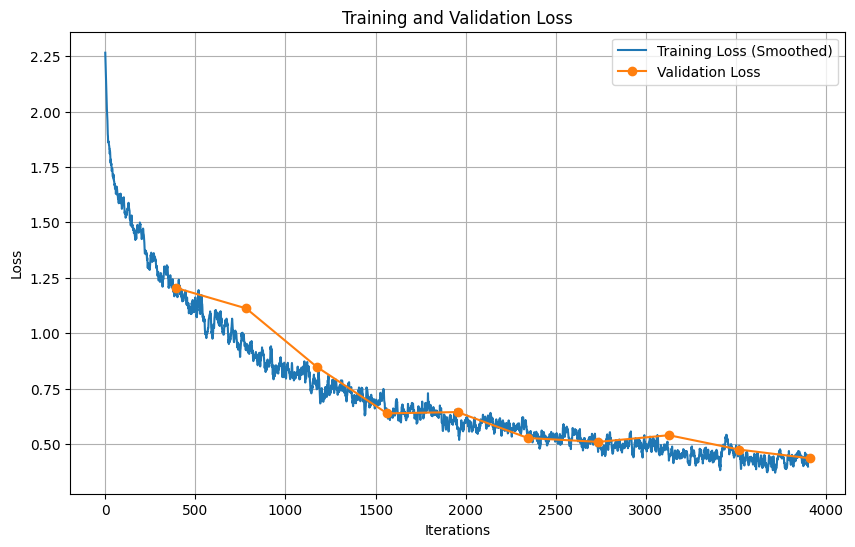

In [12]:
start = time.time()
val_acc = get_acc(model, val_loader)
end = time.time()

print('Batch_size={}, epochs={}, lr={}'.format(128, epochs, lr))
print('Val accuracy =', val_acc)
print("Process validation time: {:0.4f} s".format(end - start))

plot_losses(train_losses, val_losses)

The MobileNet paper claims it is 8 to 9 times faster than standard convolution. Using the theoretical computations of FLOPs for standard convolution and depthwise separable convolution, explain how this number was calculated.


Standard Convolution FLOPs:  
2 * C_in * C_out * K^2 * H * W

Depthwise Separable Convolution FLOPs:  
(2 * C_in * K^2 * H * W) + (2 * C_in * C_out * H * W)

Ratio of FLOPs:  
Ratio = (C_out * K^2)/(K^2 + C_out)

For K = 3, C_in = 32, C_out = 64:  
Ratio = 7.9

Depthwise separable convolution reduces FLOPs by a factor of 8 or 9 making it significantly faster by reducing expensive kernel computations

## 2.Normal CNN
In this part, we will give you a new architecture that is like MobileNet. But this time we will use normal CNN. The model is implemented and you should train it for 2 epochs. So now you can compare its speed in training and validating with your MobileNet.(Note that the accuracy is not important in this part)

In [13]:
class NormalCNN(nn.Module):
    def __init__(self, n_class=1000):
        super().__init__()


        self.model = nn.Sequential(
            conv_bn(  3,  32, 2),
            conv_bn( 32,  64, 1),
            conv_bn( 64, 128, 2),
            conv_bn(128, 128, 1),
            conv_bn(128, 256, 2),
            conv_bn(256, 256, 1),
            conv_bn(256, 512, 2),
            conv_bn(512, 512, 1),
            conv_bn(512, 512, 1),
            conv_bn(512, 512, 1),
            conv_bn(512, 512, 1),
            conv_bn(512, 512, 1),
            conv_bn(512, 1024, 2),
            conv_bn(1024, 1024, 1),
            nn.AvgPool2d(7),
        )
        self.fc = nn.Linear(1024, n_class)

    def forward(self, x):
        x = self.model(x)
        x = x.view(-1, 1024)
        x = self.fc(x)
        return x

In [14]:
epochs = 2
lr = 1e-3
model = NormalCNN(10).to(device)
start_time = time.time()
train_losses, val_losses = train(train_loader, val_loader, model, epochs, lr)
training_time = time.time() - start_time
print(f"Training completed in {training_time:.2f} seconds.")

Epoch 1/2


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.8541 | Val Loss: 1.6693
Epoch 2/2


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.5338 | Val Loss: 1.4414
Training completed in 753.61 seconds.


  0%|          | 0/79 [00:00<?, ?it/s]

Batch_size=128, epochs=2, lr=0.001
Val accuracy = 0.4841
Process validation time: 22.6251 s


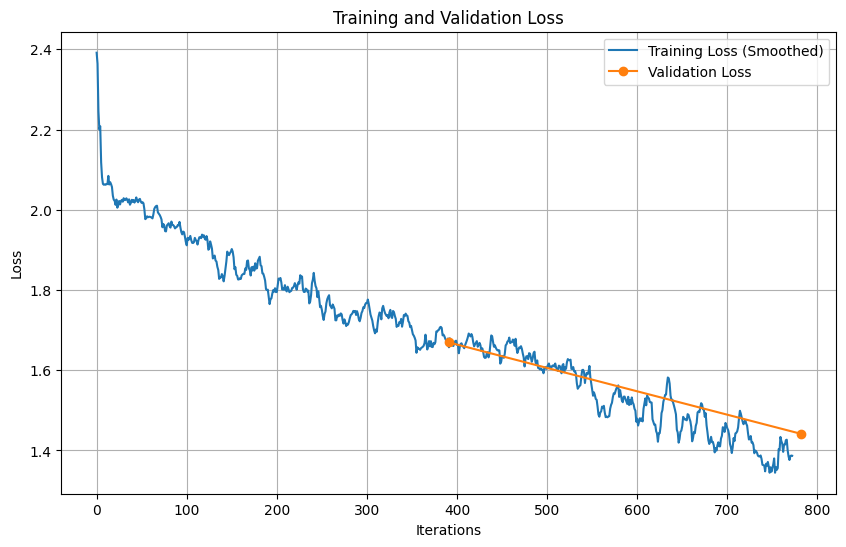

In [15]:
start = time.time()
val_acc = get_acc(model, val_loader)
end = time.time()

print('Batch_size={}, epochs={}, lr={}'.format(128, epochs, lr))
print('Val accuracy =', val_acc)
print("Process validation time: {:0.4f} s".format(end - start))

plot_losses(train_losses, val_losses)

Compare speed of learning and validating in normal CNN vs MobileNet

Learning Speed: MobileNet is faster due to fewer parameters and reduced FLOPs allowing quicker forward and backward passes.
Validation Speed: MobileNet is faster as depthwise separable convolutions reduce computations by 8–9x, making inference more efficient

MobileNet outperforms normal CNNs in both training and validation speed, especially on resource-constrained devices

In [16]:
# TODO: compare number of parameters in these two models
normal_cnn_model = NormalCNN(10)
mobilenet_model = MobileNet(10)
normal_params = sum(p.numel() for p in normal_cnn_model.parameters())
mobilenet_params = sum(p.numel() for p in mobilenet_model.parameters())
print(f"NormalCNN parameters: {normal_params}")
print(f"MobileNet parameters: {mobilenet_params}")

NormalCNN parameters: 28279338
MobileNet parameters: 3217226


## 3.Transfer Learning
Now imagine that you have a well trained model of CIFAR10 and now you want to use transfer learning for a new task of classifying CIFAR100 dataset. in the next cell, you should load your good trained model with an accuracy of 80% on validation data from disk (you should have saved your good model). or use our model (model.pt) and use their parameters for a new model for classifying 100 classes.

In [17]:
model = MobileNet(n_class=100).to(device)

# Load the pre-trained weights for the layers that match (excluding the final fc layer)
pretrained_dict = torch.load('model.pt', map_location=device, weights_only=True)
model_dict = model.state_dict()

# Filter out unnecessary keys from the pretrained dict
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict and v.size() == model_dict[k].size()}

# Load the updated state dict into the model
model_dict.update(pretrained_dict)
model.load_state_dict(model_dict)

<All keys matched successfully>

**Freezing Layers** </br>
To make the best use of transfer learning, you should freeze the initial layers (usually up to the last few convolutional blocks) and only fine-tune the final layers. This way, the model retains most of the learned low-level features from CIFAR-10, while also adapting to CIFAR-100.

In MobileNet, it’s generally effective to freeze layers up to the point where the most complex, high-level features are computed, typically around the 7th or 8th convolutional block.

In [18]:
# Freeze up to the desired layer (e.g., the first 7 layers)
layer_cnt = 1
for layer in model.model.children():
    if layer_cnt > 7:
        break
    layer_cnt += 1
    for param in layer.parameters():
        param.requires_grad = False

**Fine-tuning the Model** </br>

With the above setup, you can now train the model on CIFAR-100 using a lower learning rate. A good approach would be to:

Set a slightly lower learning rate (e.g., 1e-4) for the fine-tuning process.

But first get the dataset of CIFAR100.

In [19]:
# TRAIN DATA
train_set100 = torchvision.datasets.CIFAR100(
    root='./data', train=True, download=True, transform=transform_train)

indices = np.arange(20000)
train_set100 = Subset(train_set100, indices)

train_loader100 = torch.utils.data.DataLoader(
    train_set100, batch_size=128, shuffle=True, num_workers=2)

# VALIDATION DATA
val_set100 = torchvision.datasets.CIFAR100(
    root='./data', train=False, download=True, transform=transform_test)

val_loader100 = torch.utils.data.DataLoader(
    val_set100, batch_size=128, shuffle=False, num_workers=2)


100%|██████████| 169001437/169001437 [00:02<00:00, 73591453.45it/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


Now show 16 images of your data two times to see the images and how our data augmentaion worked. Also print labels to see the format.

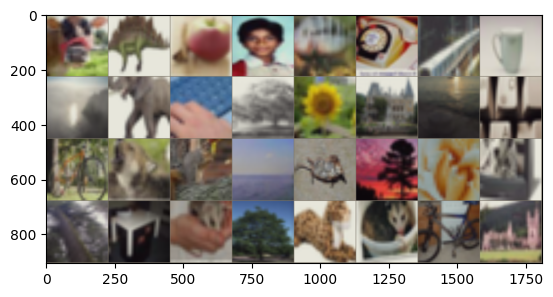

tensor([19, 29,  0, 11,  1, 86, 90, 28, 23, 31, 39, 96, 82, 17, 71, 39,  8, 97,
        80, 71, 74, 59, 70, 87, 59, 84, 64, 52, 42, 64,  8, 17, 47, 65, 21, 22,
        81, 11, 24, 84, 78, 45, 49, 97, 56, 76, 11, 90, 89, 78, 73, 14, 87,  9,
        71,  6, 47, 20, 98, 47, 36, 55, 72, 43, 51, 35, 83, 33, 27, 53, 92, 50,
        15, 89, 36, 18, 89, 46, 33, 42, 39, 64, 75, 38, 23, 42, 66, 77, 49, 18,
        46, 15, 35, 69, 95, 83, 75, 99, 73, 93, 55, 39,  4, 97, 61, 93, 51, 69,
        56, 84, 59, 64, 94,  4, 11, 33, 68, 38, 20, 33, 34, 32, 46, 53, 88, 67,
        70, 64])


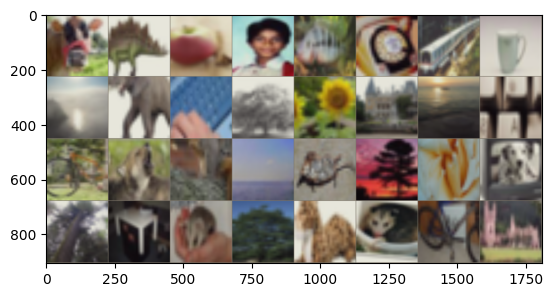

In [20]:
# show some training images with shuffle=False and labels
train_loader100_not_shuffled = torch.utils.data.DataLoader(train_set100, batch_size=128, shuffle=False)
data_iter = iter(train_loader100_not_shuffled)
images, labels = next(data_iter)
imshow(torchvision.utils.make_grid(images[:32], nrow=8))
print(labels)

# show them again to check the augmentation
data_iter = iter(train_loader100_not_shuffled)
images2, labels2 = next(data_iter)
imshow(torchvision.utils.make_grid(images2[:32], nrow=8))

Do CIFAR10 and CIFAR100 use the same images but with diffrent labesl?(maybe you should search)

CIFAR-10 and CIFAR-100 datasets do not use the same images but are constructed similarly in terms of image dimensions and dataset size. CIFAR-10 consists of 60,000 32x32 color images categorized into 10 mutually exclusive classes, with each class containing 6,000 images. In contrast, CIFAR-100 also contains 60,000 images but is divided into 100 fine-grained classes and 20 coarse-grained superclasses. Each image in CIFAR-100 has both a fine and coarse label​

Now train your model using your functions.

In [21]:
epochs = 7
lr = 2e-4
train_losses, val_losses = train(train_loader100, val_loader100, model, epochs, lr)

Epoch 1/7


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 4.3408 | Val Loss: 4.2002
Epoch 2/7


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 3.9340 | Val Loss: 3.9467
Epoch 3/7


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 3.7341 | Val Loss: 3.6987
Epoch 4/7


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 3.5615 | Val Loss: 3.6591
Epoch 5/7


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 3.4295 | Val Loss: 3.5398
Epoch 6/7


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 3.3259 | Val Loss: 3.4624
Epoch 7/7


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 3.2306 | Val Loss: 3.3424


Get some metrics and plot your losses.

  0%|          | 0/79 [00:00<?, ?it/s]

Batch_size=128, epochs=7, lr=0.0002
Val accuracy = 0.1937
Process validation time: 13.0426 s


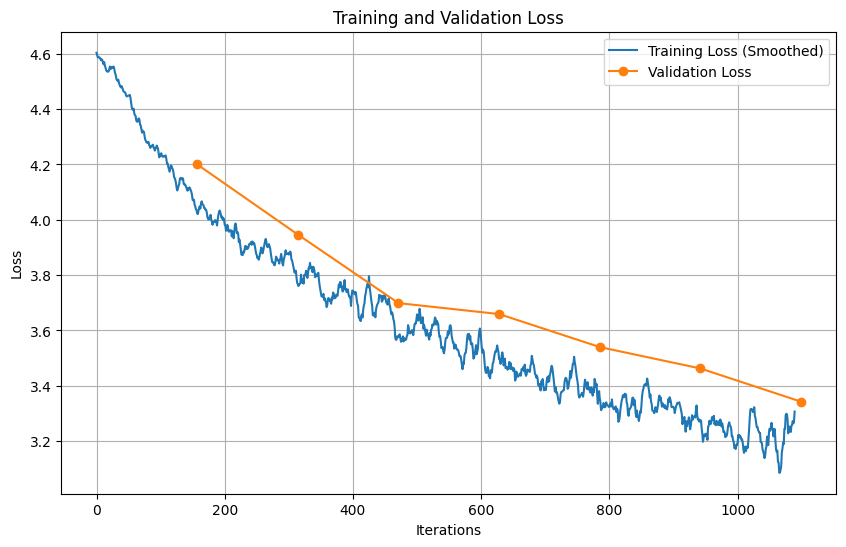

In [22]:
start = time.time()
val_acc = get_acc(model, val_loader100)
end = time.time()

print('Batch_size={}, epochs={}, lr={}'.format(128, epochs, lr))
print('Val accuracy =', val_acc)
print("Process validation time: {:0.4f} s".format(end - start))

plot_losses(train_losses, val_losses)

## 4. MobileNet V2

### Theory
MobileNet V2 builds on the concepts of MobileNet V1, introducing two significant improvements:


- **Inverted Residuals**: One of the most notable features of MobileNet V2 is the use of inverted residual blocks. Unlike traditional residual blocks that connect layers of the same depth, inverted residuals connect layers with different depths, allowing for more efficient information flow and reducing computational complexity.
- **Linear Bottlenecks**: MobileNet V2 introduces linear bottlenecks between the layers. These bottlenecks help preserve the information by maintaining low-dimensional representations, which minimizes information loss and improves the overall accuracy of the model.
- **Depthwise Separable Convolutions**: Similar to MobileNet V1, MobileNet V2 employs depthwise separable convolutions to reduce the number of parameters and computations. This technique splits the convolution into two separate operations: depthwise convolution and pointwise convolution, significantly reducing computational cost.
- **ReLU6 Activation Function**: MobileNet V2 uses the ReLU6 activation function, which clips the ReLU output at 6. This helps prevent numerical instability in low-precision computations, making the model more suitable for mobile and embedded devices.

These innovations enable MobileNet V2 to achieve better accuracy with minimal increase in complexity, making it highly suitable for mobile applications.

You can learn more about MobileNetv2 [here](https://arxiv.org/abs/1801.04381).

One of the paper’s major contributions is the linear bottleneck. In deep learning, especially in low-dimensional spaces, using non-linear layers like ReLU after compressing data can cause important information to be lost. MobileNetV2 addresses this by using linear layers instead of ReLU in the bottleneck stages.


![lb](https://miro.medium.com/v2/resize:fit:720/format:webp/1*YGVXczC3hYtey2z-9MBkPw.png)


Another key innovation in MobileNetV2 is the inverted residual block. Unlike traditional residual blocks (such as those used in ResNet), which expand first and then compress, inverted residuals do the opposite. In MobileNetV2, the input is first compressed and then expanded back to the original dimensions.

![irb](https://miro.medium.com/v2/resize:fit:640/format:webp/1*KyvQcI3Z8AxPpxjLpzrRdg.png)

As shown above, the inverted residual block (b) uses shortcuts, similar to those used in ResNet, but it compresses first and expands second, which makes it more efficient. This “inversion” allows for significant improvements in efficiency by reducing the number of operations required. To maintain performance, shortcuts (or skip connections) are used between the bottleneck layers, ensuring smooth gradient flow during training and preventing the loss of important information.

Now where are going to implement the model. First complete the below functions and class.

What is ReLU6 Activation Function? Why do we use that?

ReLU6 outputs to the range ([0, 6]). It is used in models like MobileNetV2 for:

Numerical Stability: Prevents instability in low-precision computations common in mobile and embedded systems.
Efficiency: Limits activation range, optimizing performance in constrained environments.
Bounded Gradients: Caps gradients to stabilize training.

so this makes it good for lightweight models designed for resource-limited devices.

In [23]:

def conv_bn(inp, oup, stride):
    # Standard convolution followed by batch normalization and ReLU6 activation
    # inp: input channels
    # oup: output channels
    # stride: stride for the convolution layer
    return nn.Sequential(
        nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU6(inplace=True)
    )

def conv_1x1_bn(inp, oup):
    # 1x1 pointwise convolution followed by batch normalization and ReLU6 activation
    # inp: input channels
    # oup: output channels
    return nn.Sequential(
        nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU6(inplace=True)
    )

class InvertedResidual(nn.Module):
    def __init__(self, inp, oup, stride, expand_ratio):
        # Inverted Residual block with optional skip connection
        # inp: input channels
        # oup: output channels
        # stride: stride for depthwise convolution
        # expand_ratio: multiplier for the hidden dimension size
        super(InvertedResidual, self).__init__()
        self.use_res_connect = (stride == 1 and inp == oup)
        hidden_dim = int(inp * expand_ratio)

        if expand_ratio == 1:
             self.conv = nn.Sequential(
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True),
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )
        else:
            self.conv = nn.Sequential(
                nn.Conv2d(inp, hidden_dim, 1, 1, 0, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True),
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True),
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )


    def forward(self, x):
        # Forward pass with optional residual connection
        if self.use_res_connect:
            return x + self.conv(x)
        return self.conv(x)

Now create the model using the image below. Please note that you should have the width_multiplier hyperparameter in your model. we will use it later.

![architecture](https://i.sstatic.net/1RAkv.png)

In [24]:
class MobileNetV2(nn.Module):
    def __init__(self, n_class=1000, input_size=224, width_multiplier=1.0):

        interverted_residual_setting = [# t, c, n, s
                                        [1, 16, 1, 1],
                                        [6, 24, 2, 2],
                                        [6, 32, 3, 2],
                                        [6, 64, 4, 2],
                                        [6, 96, 3, 1],
                                        [6, 160, 3, 2],
                                        [6, 320, 1, 1] ]
        super(MobileNetV2, self).__init__()
        self.input_size = input_size
        # building first layer
        ic = int(32 * width_multiplier)
        self.features = [conv_bn(3, ic, 2)]
        # building inverted residual blocks
        for t, c, n, s in interverted_residual_setting:
            oc = int(c * width_multiplier)
            for i in range(n):
                if i != 0:
                    self.features.append(InvertedResidual(ic, oc, 1, expand_ratio=t))
                else:
                    self.features.append(InvertedResidual(ic, oc, s, expand_ratio=t))
                ic = oc
        # building last several layers
        self.features.append(conv_1x1_bn(ic, int(1280 * width_multiplier)))
        self.features = nn.Sequential(*self.features)
        # building classifier
        self.classifier = nn.Linear(int(1280 * width_multiplier), n_class)

    def forward(self, x):
        x = self.features(x)
        x = x.mean(3).mean(2)
        x = self.classifier(x)
        return x

How did you create linear bottlenecks? How do they help?


Linear bottlenecks in MobileNetV2 are implemented within the InvertedResidual blocks by expanding the channels, applying depthwise convolution, and then reducing the channels using a linear (non-ReLU) pointwise convolution.  

Key Benefits:
Efficient Dimensionality Reduction: Reduces parameters while retaining critical information.
Preservation of Features: Avoids information loss in low-dimensional spaces by using linear layers instead of ReLU.
Lightweight Model: Ensures high computational efficiency, ideal for mobile and embedded applications.

Train your model with CIFAR10 dataset. Set the width_multiplier with value 1.

In [25]:
model = MobileNetV2(n_class=10).to(device)
epochs = 10
lr = 1e-3
train_losses, val_losses = train(train_loader, val_loader, model, epochs, lr)


Epoch 1/10


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.5032 | Val Loss: 1.4351
Epoch 2/10


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.0862 | Val Loss: 1.0016
Epoch 3/10


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.8800 | Val Loss: 0.8531
Epoch 4/10


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.7496 | Val Loss: 0.7733
Epoch 5/10


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.6648 | Val Loss: 0.6664
Epoch 6/10


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.6111 | Val Loss: 0.6217
Epoch 7/10


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.5650 | Val Loss: 0.5961
Epoch 8/10


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.5237 | Val Loss: 0.4904
Epoch 9/10


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.4899 | Val Loss: 0.4780
Epoch 10/10


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.4630 | Val Loss: 0.5247


Get some metrics and plot your losses.

  0%|          | 0/79 [00:00<?, ?it/s]

Batch_size=128, epochs=10, lr=0.001
Val accuracy = 0.8249
Process validation time: 13.7617 s


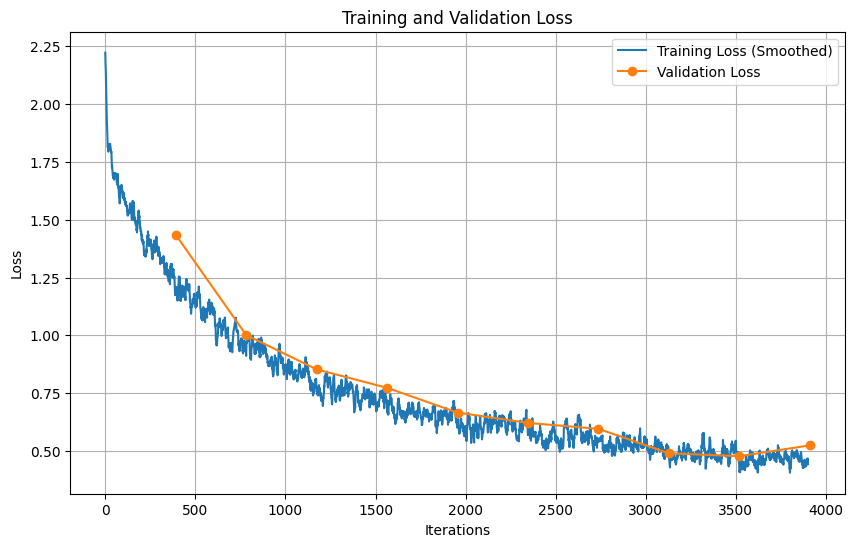

In [26]:
start = time.time()
val_acc = get_acc(model, val_loader)
end = time.time()

print('Batch_size={}, epochs={}, lr={}'.format(128, epochs, lr))
print('Val accuracy =', val_acc)
print("Process validation time: {:0.4f} s".format(end - start))

plot_losses(train_losses, val_losses)

Now we want to see the effect of the hyperparameter (width multiplier) in our model. For all values between 0.1 to 1 with step 0.1 print the number of parameters.

In [27]:
for wm in [i / 10 for i in range(1, 11)]:
    model = MobileNetV2(n_class=10, width_multiplier=wm)
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Width Multiplier: {wm}, Number of Parameters: {num_params}")

Width Multiplier: 0.1, Number of Parameters: 31255
Width Multiplier: 0.2, Number of Parameters: 105224
Width Multiplier: 0.3, Number of Parameters: 221676
Width Multiplier: 0.4, Number of Parameters: 380438
Width Multiplier: 0.5, Number of Parameters: 587178
Width Multiplier: 0.6, Number of Parameters: 826943
Width Multiplier: 0.7, Number of Parameters: 1113168
Width Multiplier: 0.8, Number of Parameters: 1441788
Width Multiplier: 0.9, Number of Parameters: 1812806
Width Multiplier: 1.0, Number of Parameters: 2236682


Now load the pretrained model that we trained with width_multiplier=1/2 for 15 epoches. then compare it's accuracy and time it needs for validation data with normal MobileNetv2 model.

In [28]:
# in original code it was this
# MNv2_path = './MNv2WMmodel.pt'
# but i changed to this to make it ok in my system
MNv2_path = '/kaggle/input/mnv2wmmodel/other/default/1/MNv2WMmodel.pt'
model = MobileNetV2(n_class=10, width_multiplier=0.5).to(device)
model.load_state_dict(torch.load(MNv2_path))

/tmp/ipykernel_23/1873057993.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MNv2_path))


<All keys matched successfully>

In [29]:
start = time.time()
val_acc = get_acc(model, val_loader)
end = time.time()

print('Val accuracy =', val_acc)
print("Process validation time: {:0.4f} s".format(end - start))



  0%|          | 0/79 [00:00<?, ?it/s]

Val accuracy = 0.7432
Process validation time: 12.1441 s


Explain how this hyperparameter changes the number of parameters in theory. Write a formula to predict its effect without actually creating the models. Compare your formula with the above numbers and if they dont match perfectly explain a bit.

The number of parameters in MobileNetV2 is influenced by the width multiplier a, which scales the input and output channels across the network. The formula to predict its effect is:

Adjusted Parameters = (a . C_in) . (a . C_out) . K^2 + (a . C_out)

Adjusted Depthwise Parameters = (a . C_in) . K^2

Adjusted Pointwise Parameters = (a . C_in) . (a . C_out)

Sum the contributions from all layers, including residual connections and batch normalization layers

Compare:

Batch normalization parameters, adding scale and shift for each channel.

Fully connected layers, which may not scale with a.

Implementation-specific optimizations, rounding effects, or ignored minor layers.

Another hyperparameter is resolution multiplier. Can it make our model faster? Does it decrease the number of parameters? Explain.

The resolution multiplier can indeed make the model faster but does not decrease the number of parameters:
Reducing the input resolution decreases the spatial dimensions (H * W) of feature maps in every layer, reducing the computational workload (FLOPs). This results in faster processing.
The number of parameters remains unchanged because it depends on the architecture and is independent of the input resolution.
it makes the model faster and it does not reduce the number of parameters.

Why is the number of parameters important for us? Now we have GPUs that can increase performance considerably. Is the number of parameters really a big deal?

yes.

Memory Usage: Larger models need more memory for storage and training.

Inference Time: Fewer parameters result in faster predictions, crucial for real-time tasks.

Energy Efficiency: Smaller models consume less energy, essential for mobile and sustainable applications.

Deployment Feasibility: Compact models are easier to deploy on devices with limited resources or bandwidth.

Scalability: Reducing parameters lowers operational costs in large-scale systems.

Despite GPUs enhancing computational power, these considerations ensure parameter optimization remains vital.

## 5.Knowledge Distillation

Now we learn how you can implement knowledge distillation using a pre-trained ResNet as the teacher model and MobileNetV2 as the student model for the CIFAR-10 dataset.

Knowledge distillation is a process where a smaller, more efficient model (the student) is trained to replicate the behavior of a larger, more complex model (the teacher). This is particularly useful for deploying models on resource-constrained devices where efficiency and speed are critical.

You can learn more about the loss function we use for this porpuse [here](
https://medium.com/@aryamaanthakur/knowledge-distillation-make-your-neural-networks-smaller-398485f811c6)

First create our teacher.(Pay attention that we need to finetune this teacher for out task, but because of lack of resources we will just use it with terrible accuracy)

In [30]:
import timm

# Load a pre-trained ResNet18 fine-tuned on CIFAR-10
teacher_model = timm.create_model('resnet18', pretrained=True, num_classes=10)
teacher_model = teacher_model.to(device)

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

In [31]:
start = time.time()
val_acc = get_acc(teacher_model, val_loader)
end = time.time()

print('Val accuracy =', val_acc)
print("Process validation time: {:0.4f} s".format(end - start))


  0%|          | 0/79 [00:00<?, ?it/s]

Val accuracy = 0.1037
Process validation time: 13.1938 s


Now create a mobilenetv2 model and then write the code to train it with Knowledge Distillation.

In [32]:
class DistillationLoss(nn.Module):
    """
    Custom loss function for knowledge distillation combining KL divergence
    and cross-entropy loss.

    Args:
        temperature (float): Temperature parameter for scaling logits.
        alpha (float): Weighting factor for distillation and classification loss.
    """
    def __init__(self, temperature: float = 3.0, alpha: float = 0.5):
        super(DistillationLoss, self).__init__()
        self.temperature = temperature
        self.alpha = alpha
        self.kl_div = nn.KLDivLoss(reduction='batchmean')

    def forward(self,
                student_logits: torch.Tensor,
                teacher_logits: torch.Tensor,
                labels: torch.Tensor) -> torch.Tensor:
        """
        Compute the combined distillation and classification loss.

        Args:
            student_logits (torch.Tensor): Logits from the student model.
            teacher_logits (torch.Tensor): Logits from the teacher model.
            labels (torch.Tensor): Ground truth labels.

        Returns:
            torch.Tensor: The computed loss value.
        """
        tp = F.softmax(teacher_logits / self.temperature, dim=1)
        slp = F.log_softmax(student_logits / self.temperature, dim=1)
        distillation_loss = self.kl_div(slp, tp) * (self.temperature ** 2)
        classification_loss = F.cross_entropy(student_logits, labels)
        loss = self.alpha * distillation_loss + (1 - self.alpha) * classification_loss
        return loss


def train_student(teacher: nn.Module,
                  student: nn.Module,
                  train_loader: torch.utils.data.DataLoader,
                  test_loader: torch.utils.data.DataLoader,
                  device: torch.device,
                  epochs: int = 10,
                  lr: float = 0.01) -> None:
    """
    Train a student model using knowledge distillation.

    Args:
        teacher (nn.Module): Pre-trained teacher model.
        student (nn.Module): Student model to train.
        train_loader (torch.utils.data.DataLoader): DataLoader for training data.
        test_loader (torch.utils.data.DataLoader): DataLoader for test data.
        device (torch.device): Device to perform training on (CPU or GPU).
        epochs (int): Number of training epochs. Default is 10.
        lr (float): Learning rate for the optimizer. Default is 0.01.
    """
    teacher.to(device).eval()
    student.to(device)

    c = DistillationLoss(temperature=3.0, alpha=0.5)
    optimizer = optim.Adam(student.parameters(), lr=lr)

    for epoch in range(epochs):
        student.train()
        running_loss = 0.0
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            images, labels = images.to(device), labels.to(device)
            with torch.no_grad():
                teacher_logits = teacher(images)
            sl = student(images)
            loss = c(sl, teacher_logits, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_loader):.4f}")

Train it for one epoch to just check if it works.

In [33]:
student = MobileNetV2(n_class=10)

train_student(teacher_model, student, train_loader, val_loader, device, epochs=1, lr=0.001)

Epoch 1/1:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 1/1, Loss: 0.9434


What are the potential trade-offs of using a high value of alpha (e.g., 0.9) versus a low value of alpha (e.g., 0.1) in the DistillationLoss? How might these trade-offs impact the student model's performance in terms of generalization to the target task and alignment with the teacher's knowledge?

High Alpha: Better alignment with task-specific goals but risks overfitting and reduced generalization.

Low Alpha: Promotes broader generalization but risks underfitting to specific task details.

Balanced Alpha (like 0.5): A compromise between generalization and task-specific precision, leveraging both the ground truth and the teacher's distilled knowledge.
The choice of alpha should be guided by the specific requirements of the application: whether the priority is generalization across datasets or precision on the target task.

## Summary
- **MobileNet V1**: Introduced depthwise separable convolutions, significantly reducing computation and model size.
- **MobileNet V2**: Added inverted residuals and linear bottlenecks to improve efficiency and performance, reducing memory use without sacrificing accuracy.

These architectures are optimized for mobile and embedded applications, providing a balance between accuracy and efficiency through lightweight, effective design.

question for yourself: What new features and innovations did MobileNetV3 introduce to improve both efficiency and accuracy over its predecessors? Explore its design choices and how they further optimize MobileNet for real-time applications and mobile deployment.

## Refrences

[1] Andrew G. Howard, Menglong Zhu, Bo Chen,
Dmitry Kalenichenko, Weijun Wang, Tobias
Weyand, Marco Andreetto, and Hartwig Adam. Mobilenets: Efficient convolutional neural networks for mobile vision applications. CoRR,
abs/1704.04861, 2017

[2] Mark Sandler, Andrew G. Howard, Menglong Zhu, Andrey
Zhmoginov, and Liang-Chieh Chen. Mobilenetv2: Inverted
residuals and linear bottlenecks. mobile networks for classification, detection and segmentation. CoRR, abs/1801.04381,
2018